# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

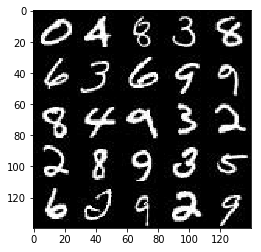

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

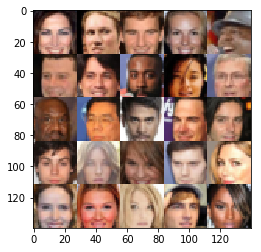

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z    = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr          = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, filters=64, 
                              kernel_size=5, strides=(2, 2), padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        lrelu1 = tf.maximum(alpha*bn1, bn1)
        
        x2 = tf.layers.conv2d(lrelu1, filters=128,
                              kernel_size=5, strides=(2, 2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(lrelu2, filters=256,
                             kernel_size=5, strides=(2, 2), padding='same')
        bn3 =  tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha*bn3, bn3)
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x256

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x out_channel_dim
        
        # scale tanh -1,1 to -0.5,0.5 range
        out = tf.tanh(logits)/2
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    # model_inputs
    data_len, img_w, img_h, img_c = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_c, z_dim)
    
    # model_loss graphs
    d_loss, g_loss = model_loss(input_real, input_z, img_c)
    
    # model_optimizer
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    
    print_every=100
    show_every=100
    figsize=(16,16)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _, train_loss_d = sess.run([d_opt, d_loss], feed_dict={input_z: batch_z, input_real: x, lr: learning_rate})
                _, train_loss_g = sess.run([g_opt, g_loss], feed_dict={input_z: batch_z, input_real: x, lr: learning_rate})
                
                if steps % print_every == 0:
                    print("Epoch {}/{}, step {}..".format(e+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 36, input_z, img_c, data_image_mode)

        saver.save(sess, './checkpoints/dcgan_mnist.ckpt')
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 100.. Discriminator Loss: 0.5459... Generator Loss: 4.0310


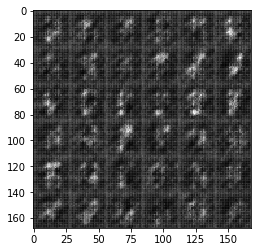

Epoch 1/2, step 200.. Discriminator Loss: 0.5919... Generator Loss: 3.8155


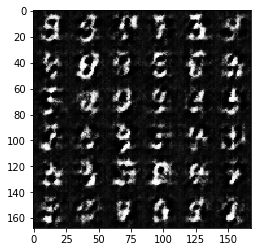

Epoch 1/2, step 300.. Discriminator Loss: 0.7032... Generator Loss: 2.0915


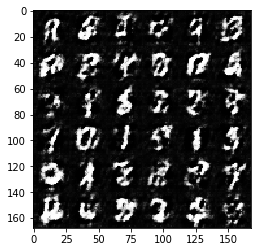

Epoch 1/2, step 400.. Discriminator Loss: 0.5087... Generator Loss: 3.3995


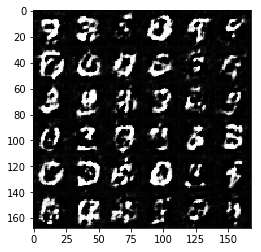

Epoch 1/2, step 500.. Discriminator Loss: 0.6815... Generator Loss: 1.9900


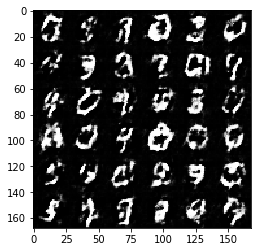

Epoch 1/2, step 600.. Discriminator Loss: 0.4890... Generator Loss: 3.4024


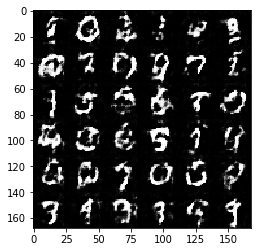

Epoch 1/2, step 700.. Discriminator Loss: 0.6809... Generator Loss: 4.4713


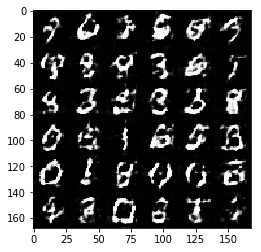

Epoch 1/2, step 800.. Discriminator Loss: 0.6323... Generator Loss: 4.0548


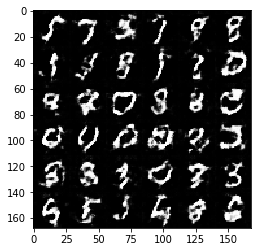

Epoch 1/2, step 900.. Discriminator Loss: 0.5388... Generator Loss: 3.1590


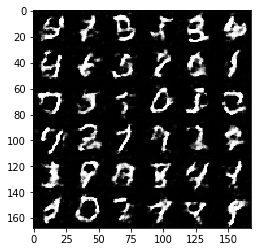

Epoch 1/2, step 1000.. Discriminator Loss: 0.6423... Generator Loss: 2.1912


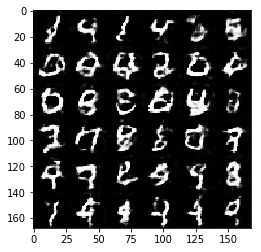

Epoch 1/2, step 1100.. Discriminator Loss: 0.4585... Generator Loss: 2.6890


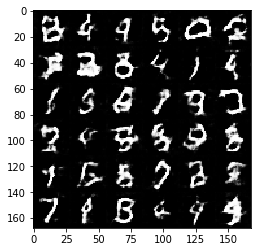

Epoch 1/2, step 1200.. Discriminator Loss: 0.5238... Generator Loss: 3.4413


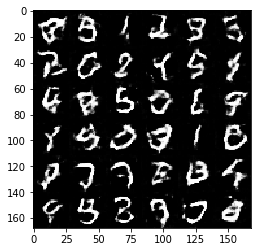

Epoch 1/2, step 1300.. Discriminator Loss: 0.5073... Generator Loss: 2.9947


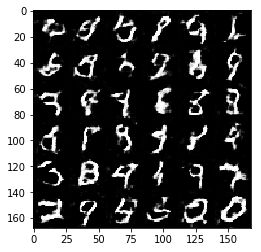

Epoch 1/2, step 1400.. Discriminator Loss: 1.3521... Generator Loss: 0.3740


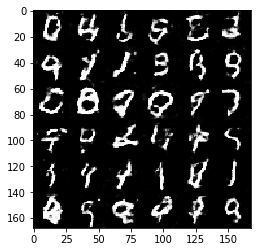

Epoch 1/2, step 1500.. Discriminator Loss: 0.4814... Generator Loss: 3.1477


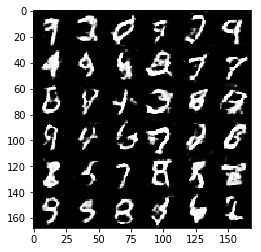

Epoch 1/2, step 1600.. Discriminator Loss: 0.5653... Generator Loss: 3.3541


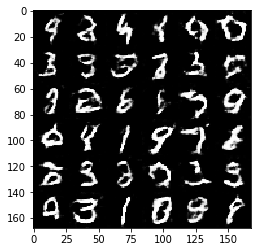

Epoch 1/2, step 1700.. Discriminator Loss: 0.4571... Generator Loss: 3.7090


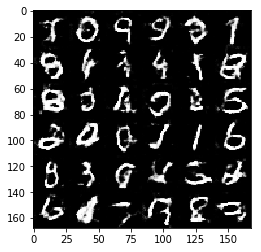

Epoch 1/2, step 1800.. Discriminator Loss: 0.4220... Generator Loss: 4.1811


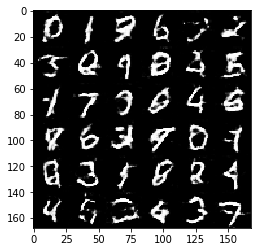

Epoch 2/2, step 1900.. Discriminator Loss: 0.7244... Generator Loss: 3.6046


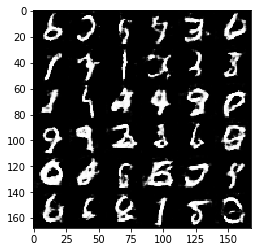

Epoch 2/2, step 2000.. Discriminator Loss: 0.4852... Generator Loss: 3.4079


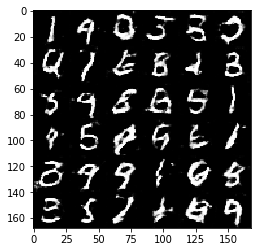

Epoch 2/2, step 2100.. Discriminator Loss: 0.4114... Generator Loss: 3.4136


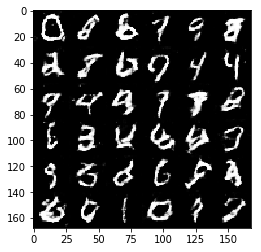

Epoch 2/2, step 2200.. Discriminator Loss: 0.7978... Generator Loss: 1.5353


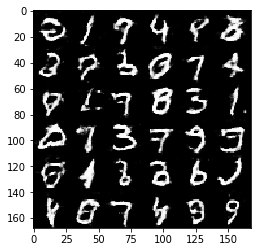

Epoch 2/2, step 2300.. Discriminator Loss: 0.6455... Generator Loss: 1.6296


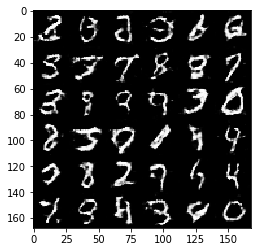

Epoch 2/2, step 2400.. Discriminator Loss: 0.5128... Generator Loss: 3.0160


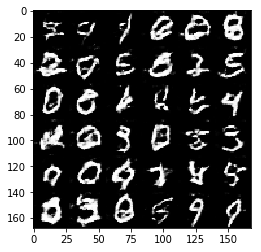

Epoch 2/2, step 2500.. Discriminator Loss: 0.4746... Generator Loss: 3.6513


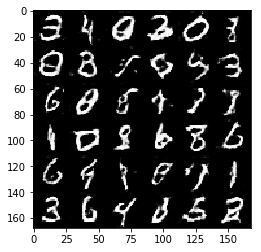

Epoch 2/2, step 2600.. Discriminator Loss: 0.5819... Generator Loss: 4.1898


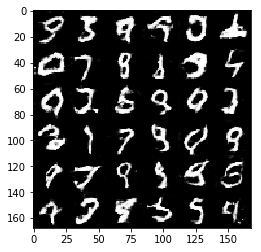

Epoch 2/2, step 2700.. Discriminator Loss: 0.8321... Generator Loss: 3.6644


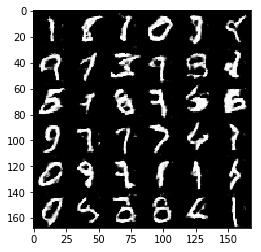

Epoch 2/2, step 2800.. Discriminator Loss: 0.7093... Generator Loss: 1.7983


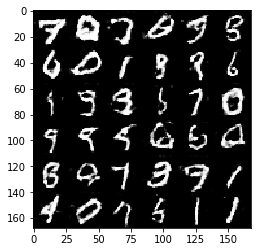

Epoch 2/2, step 2900.. Discriminator Loss: 0.4698... Generator Loss: 2.9018


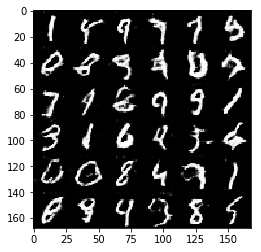

Epoch 2/2, step 3000.. Discriminator Loss: 0.4097... Generator Loss: 4.1462


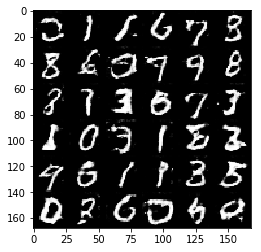

Epoch 2/2, step 3100.. Discriminator Loss: 0.6528... Generator Loss: 3.7087


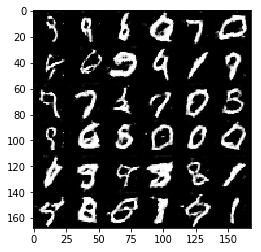

Epoch 2/2, step 3200.. Discriminator Loss: 0.8742... Generator Loss: 4.9816


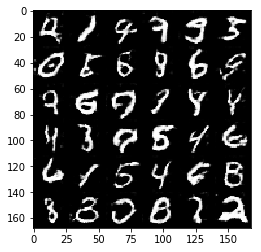

Epoch 2/2, step 3300.. Discriminator Loss: 0.5732... Generator Loss: 3.1846


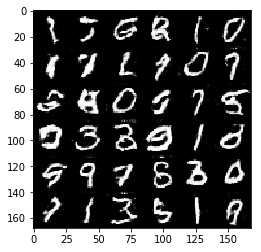

Epoch 2/2, step 3400.. Discriminator Loss: 0.4812... Generator Loss: 4.0389


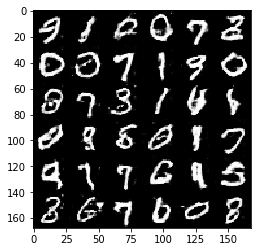

Epoch 2/2, step 3500.. Discriminator Loss: 0.4598... Generator Loss: 3.8872


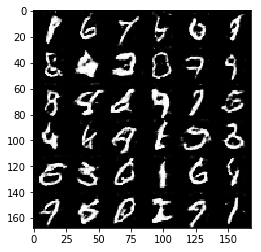

Epoch 2/2, step 3600.. Discriminator Loss: 0.4362... Generator Loss: 3.5188


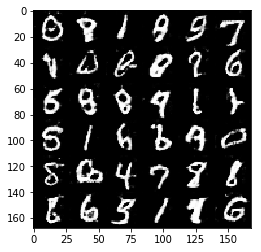

Epoch 2/2, step 3700.. Discriminator Loss: 0.4225... Generator Loss: 3.0994


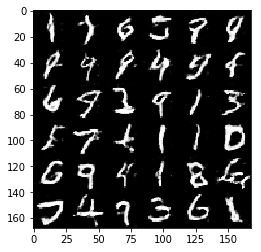

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, step 100.. Discriminator Loss: 0.4603... Generator Loss: 4.9430


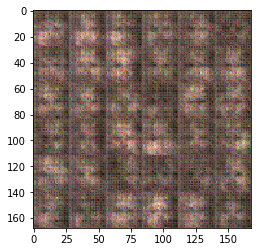

Epoch 1/1, step 200.. Discriminator Loss: 0.5651... Generator Loss: 5.8953


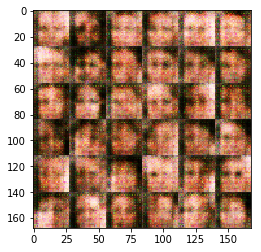

Epoch 1/1, step 300.. Discriminator Loss: 0.7010... Generator Loss: 4.0131


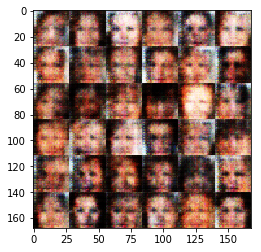

Epoch 1/1, step 400.. Discriminator Loss: 0.7533... Generator Loss: 2.6827


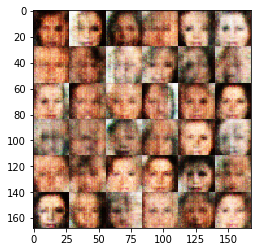

Epoch 1/1, step 500.. Discriminator Loss: 0.5493... Generator Loss: 3.3111


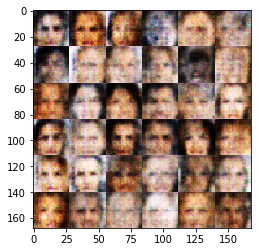

Epoch 1/1, step 600.. Discriminator Loss: 0.8147... Generator Loss: 3.5573


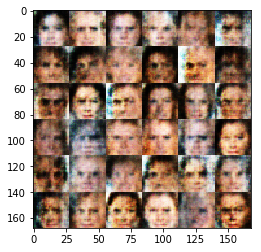

Epoch 1/1, step 700.. Discriminator Loss: 0.8461... Generator Loss: 2.3277


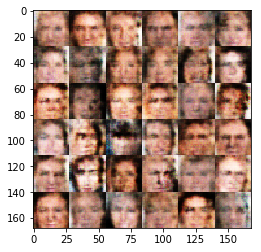

Epoch 1/1, step 800.. Discriminator Loss: 0.8019... Generator Loss: 3.0138


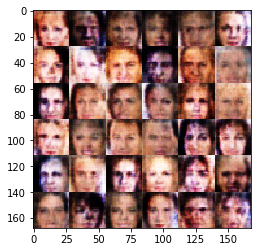

Epoch 1/1, step 900.. Discriminator Loss: 0.8429... Generator Loss: 3.3385


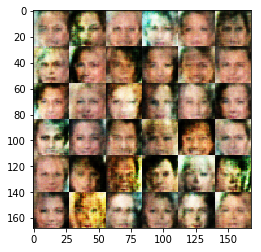

Epoch 1/1, step 1000.. Discriminator Loss: 1.0363... Generator Loss: 4.0722


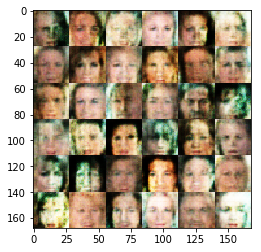

Epoch 1/1, step 1100.. Discriminator Loss: 0.8807... Generator Loss: 3.6186


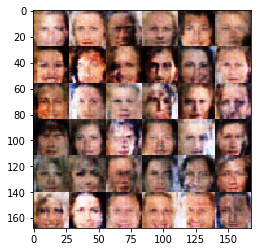

Epoch 1/1, step 1200.. Discriminator Loss: 0.7457... Generator Loss: 3.2632


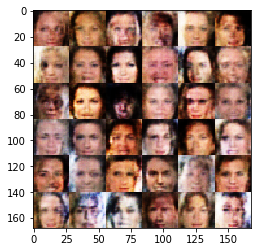

Epoch 1/1, step 1300.. Discriminator Loss: 0.8477... Generator Loss: 3.1942


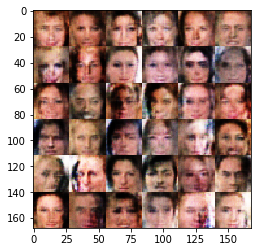

Epoch 1/1, step 1400.. Discriminator Loss: 0.8976... Generator Loss: 2.7873


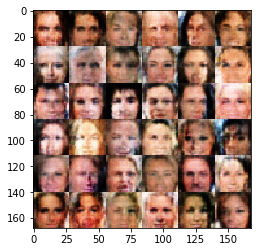

Epoch 1/1, step 1500.. Discriminator Loss: 0.8803... Generator Loss: 1.8690


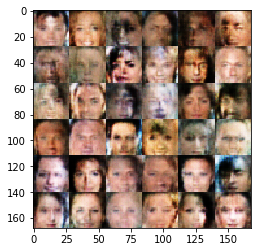

Epoch 1/1, step 1600.. Discriminator Loss: 0.7931... Generator Loss: 2.4063


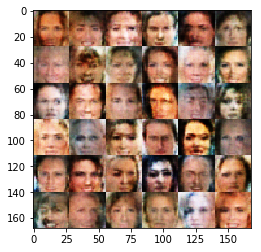

Epoch 1/1, step 1700.. Discriminator Loss: 0.8573... Generator Loss: 2.9106


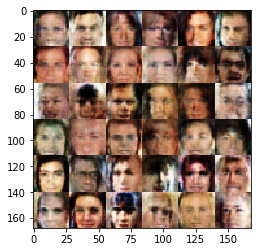

Epoch 1/1, step 1800.. Discriminator Loss: 0.8571... Generator Loss: 1.9383


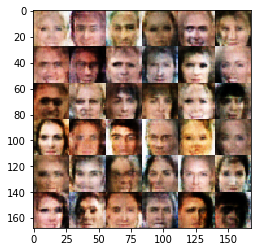

Epoch 1/1, step 1900.. Discriminator Loss: 0.9575... Generator Loss: 1.2950


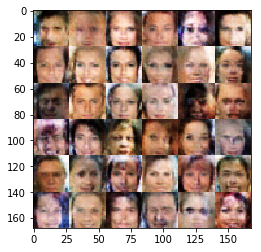

Epoch 1/1, step 2000.. Discriminator Loss: 0.7440... Generator Loss: 1.9483


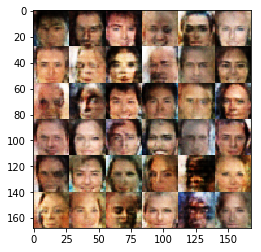

Epoch 1/1, step 2100.. Discriminator Loss: 0.9791... Generator Loss: 1.5566


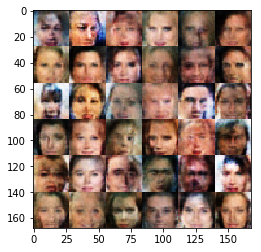

Epoch 1/1, step 2200.. Discriminator Loss: 0.7024... Generator Loss: 2.0261


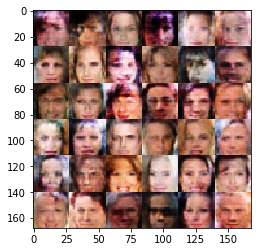

Epoch 1/1, step 2300.. Discriminator Loss: 0.9447... Generator Loss: 2.9706


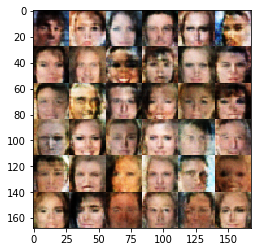

Epoch 1/1, step 2400.. Discriminator Loss: 0.5645... Generator Loss: 3.3269


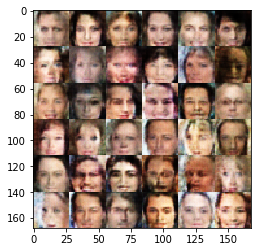

Epoch 1/1, step 2500.. Discriminator Loss: 0.8286... Generator Loss: 1.9977


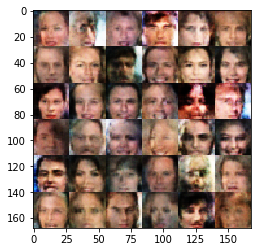

Epoch 1/1, step 2600.. Discriminator Loss: 0.8320... Generator Loss: 2.7045


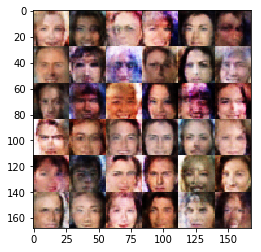

Epoch 1/1, step 2700.. Discriminator Loss: 0.7995... Generator Loss: 2.1160


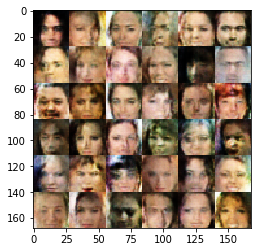

Epoch 1/1, step 2800.. Discriminator Loss: 0.7987... Generator Loss: 2.0531


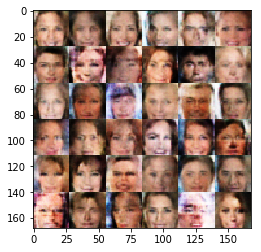

Epoch 1/1, step 2900.. Discriminator Loss: 1.0134... Generator Loss: 1.9123


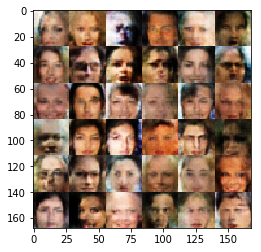

Epoch 1/1, step 3000.. Discriminator Loss: 0.7592... Generator Loss: 2.6900


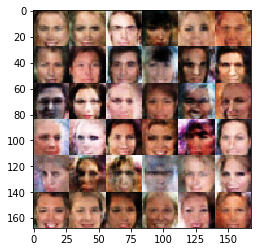

Epoch 1/1, step 3100.. Discriminator Loss: 0.9990... Generator Loss: 1.0631


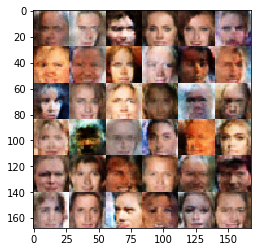

Epoch 1/1, step 3200.. Discriminator Loss: 1.3517... Generator Loss: 1.1975


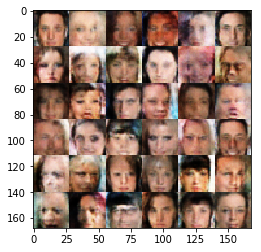

Epoch 1/1, step 3300.. Discriminator Loss: 0.6761... Generator Loss: 2.6612


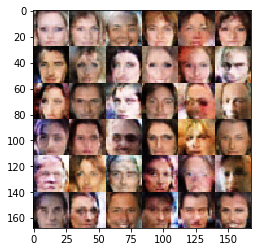

Epoch 1/1, step 3400.. Discriminator Loss: 0.8169... Generator Loss: 2.0227


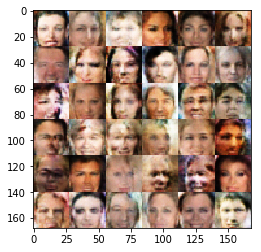

Epoch 1/1, step 3500.. Discriminator Loss: 0.8593... Generator Loss: 2.1612


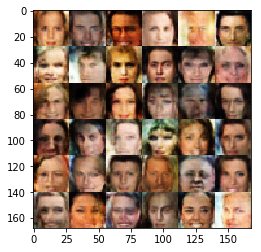

Epoch 1/1, step 3600.. Discriminator Loss: 0.6990... Generator Loss: 3.8445


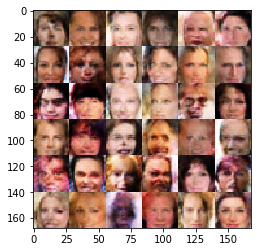

Epoch 1/1, step 3700.. Discriminator Loss: 0.7160... Generator Loss: 2.6965


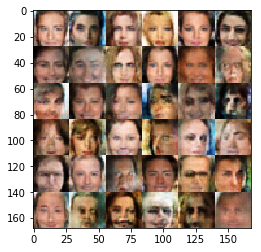

Epoch 1/1, step 3800.. Discriminator Loss: 0.7088... Generator Loss: 2.6416


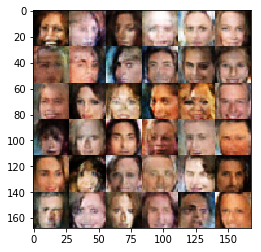

Epoch 1/1, step 3900.. Discriminator Loss: 0.8733... Generator Loss: 1.5726


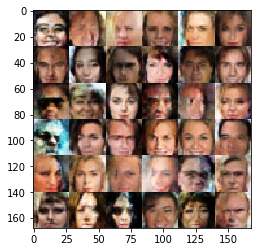

Epoch 1/1, step 4000.. Discriminator Loss: 0.7681... Generator Loss: 3.3260


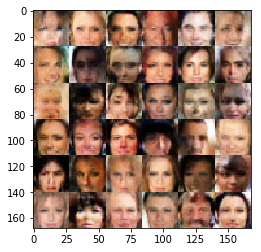

Epoch 1/1, step 4100.. Discriminator Loss: 0.9479... Generator Loss: 1.2891


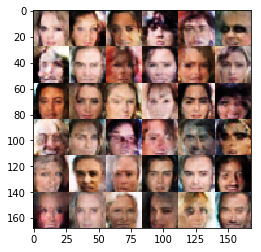

Epoch 1/1, step 4200.. Discriminator Loss: 0.6895... Generator Loss: 2.2013


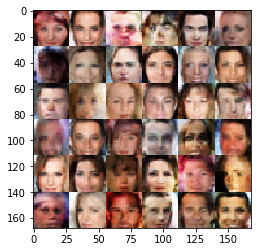

Epoch 1/1, step 4300.. Discriminator Loss: 0.8139... Generator Loss: 3.0471


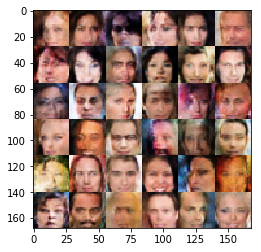

Epoch 1/1, step 4400.. Discriminator Loss: 0.8032... Generator Loss: 3.4086


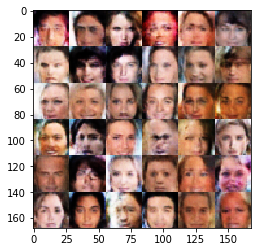

Epoch 1/1, step 4500.. Discriminator Loss: 0.8323... Generator Loss: 2.4206


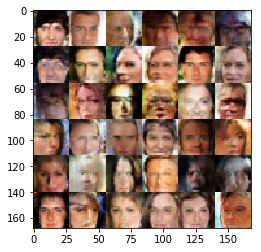

Epoch 1/1, step 4600.. Discriminator Loss: 0.6117... Generator Loss: 2.6193


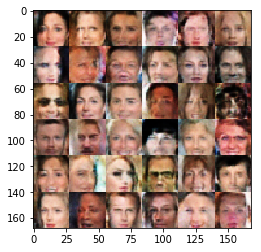

Epoch 1/1, step 4700.. Discriminator Loss: 1.0402... Generator Loss: 1.6015


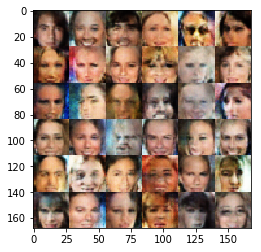

Epoch 1/1, step 4800.. Discriminator Loss: 1.1521... Generator Loss: 0.8046


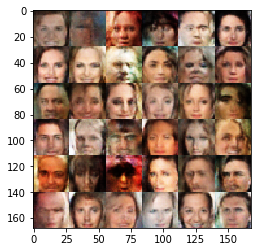

Epoch 1/1, step 4900.. Discriminator Loss: 0.7437... Generator Loss: 1.9501


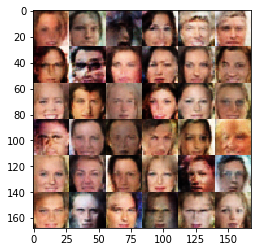

Epoch 1/1, step 5000.. Discriminator Loss: 0.9114... Generator Loss: 3.7677


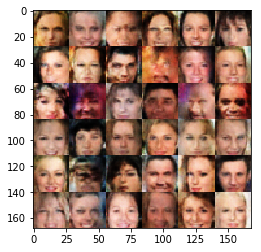

Epoch 1/1, step 5100.. Discriminator Loss: 0.7339... Generator Loss: 2.5929


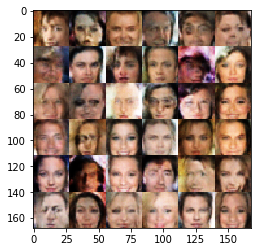

Epoch 1/1, step 5200.. Discriminator Loss: 0.7915... Generator Loss: 3.5156


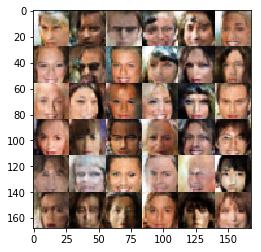

Epoch 1/1, step 5300.. Discriminator Loss: 0.8788... Generator Loss: 3.1291


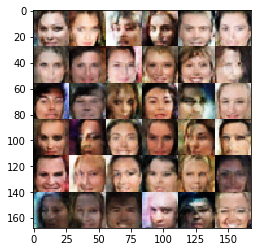

Epoch 1/1, step 5400.. Discriminator Loss: 1.0845... Generator Loss: 2.9875


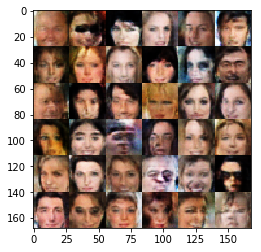

Epoch 1/1, step 5500.. Discriminator Loss: 0.6856... Generator Loss: 3.6188


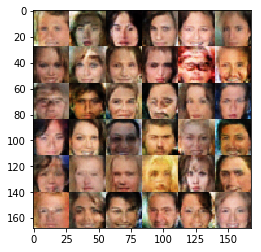

Epoch 1/1, step 5600.. Discriminator Loss: 0.9410... Generator Loss: 2.2231


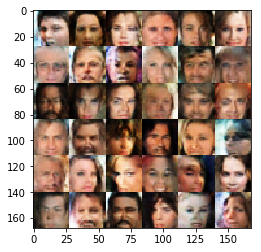

Epoch 1/1, step 5700.. Discriminator Loss: 0.8094... Generator Loss: 4.0449


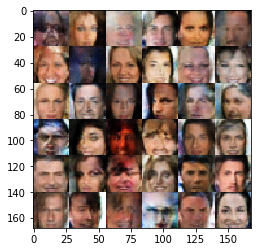

Epoch 1/1, step 5800.. Discriminator Loss: 0.6879... Generator Loss: 2.1104


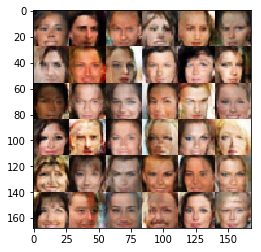

Epoch 1/1, step 5900.. Discriminator Loss: 0.8315... Generator Loss: 2.1978


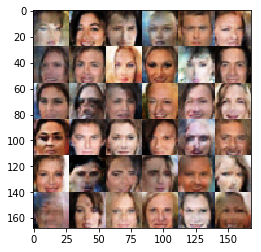

Epoch 1/1, step 6000.. Discriminator Loss: 0.8927... Generator Loss: 3.1565


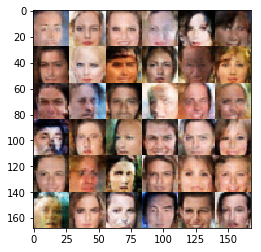

Epoch 1/1, step 6100.. Discriminator Loss: 0.6692... Generator Loss: 2.2987


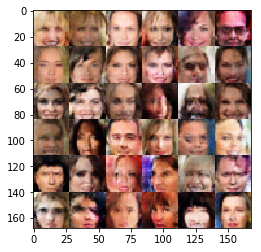

Epoch 1/1, step 6200.. Discriminator Loss: 0.8196... Generator Loss: 3.9492


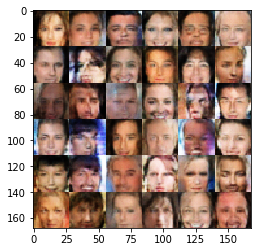

Epoch 1/1, step 6300.. Discriminator Loss: 0.9308... Generator Loss: 1.8723


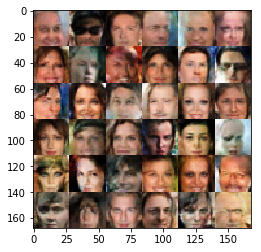

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.